# パッケージインポート

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import librosa
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# GTZANのダウンロード

In [ ]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

In [3]:
!gunzip /content/genres.tar.gz

In [ ]:
!tar -xvf /content/genres.tar

# データの準備

- 結果をまとめた画像データやテストデータの情報をgithub上から持ってくる

In [ ]:
!git clone https://github.com/KMASAHIRO/music2vec

In [8]:
# ロードする音楽ファイル名の作成
genre_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

gtzan_filenames = list()

for genre in genre_list:
  for i in range(100):
    gtzan_filenames.append("/content/genres/" + genre + "/" + genre + ".000{:02}.wav".format(i))

gtzan_filenames = np.asarray(gtzan_filenames)

In [9]:
# ラベルの作成
gtzan_labels = list()

for i in range(10):
  for k in range(100):
    gtzan_labels.append(tf.one_hot(i,10))

gtzan_labels = np.asarray(gtzan_labels)

In [10]:
# データをシャッフル(最初はジャンルごとにソートされている)
np_random = np.random.RandomState(seed=1)
new_gtzan_filenames = np_random.permutation(gtzan_filenames)
np_random = np.random.RandomState(seed=1)
new_gtzan_labels = np_random.permutation(gtzan_labels)

In [11]:
# DANetのテストデータと同じテストデータを使用する(後でDANetの出力を分類させるタスクを行うため)
with open("/content/music2vec/test_data.txt","rb") as f:
  data_dict = pickle.load(f)

lacia_test_filenames = data_dict['gtzan_filenames']
test_labels = data_dict['gtzan_labels']

In [12]:
# DANet訓練時とデータの配置場所が異なるので、ファイルのパスを変更する
test_filenames = list()
for file in lacia_test_filenames:
  splitted = file.split('/')[2:]
  test_filenames.append('/content/'+'/'.join(splitted))
test_filenames = np.asarray(test_filenames)

In [13]:
# 先に用意していた音楽ファイルの内、テストデータとなるものを抽出
duplicated_index = list()
for file in test_filenames:
  index = np.argmax(new_gtzan_filenames==file)
  duplicated_index.append(index)

In [14]:
# テストデータを用意していた音楽ファイルから取り除き、訓練データとして使用する
train_filenames = np.delete(new_gtzan_filenames,duplicated_index,axis=0)
train_labels = np.delete(new_gtzan_labels,duplicated_index,axis=0)

In [15]:
# 音楽ファイルをロードして訓練データを生成するジェネレータ
def generator(filenames, labels, batch_size):
  index = 0
  seed_num = 0
  new_filenames = filenames.copy()
  new_labels = labels.copy()
  while True:
    train_inputs = list()
    train_labels = list()
    if index+batch_size>len(filenames):
      index = 0
      np_random = np.random.RandomState(seed=seed_num)
      new_filenames = np_random.permutation(new_filenames)
      np_random = np.random.RandomState(seed=seed_num)
      new_labels = np_random.permutation(new_labels)
      seed_num += 1
    
    for i in range(batch_size):
      y,sr = librosa.load(new_filenames[index],sr=22050,mono=True,dtype=np.float32)
      y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
      y *= 256.0
      y = np.reshape(y,(-1,1))
      train_inputs.append(y)
      train_labels.append(new_labels[index])
      index += 1
    train_inputs = np.asarray(train_inputs)
    train_labels = np.asarray(train_labels)

    yield train_inputs, train_labels

In [16]:
# 訓練データをsoundnetに入力して出力を平坦化したものをpca分析するときに使うジェネレータ
def pca_generator(filenames, labels, batch_size):
  index = 0
  seed_num = 0
  new_filenames = filenames.copy()
  new_labels = labels.copy()
  while True:
    train_inputs = list()
    train_labels = list()
    if index+batch_size>len(filenames):
      batch_size = len(filenames) - index
    
    for i in range(batch_size):
      y,sr = librosa.load(new_filenames[index],sr=22050,mono=True,dtype=np.float32)
      y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
      y *= 256.0
      y = np.reshape(y,(-1,1))
      train_inputs.append(y)
      train_labels.append(new_labels[index])
      index += 1
    train_inputs = np.asarray(train_inputs)
    train_labels = np.asarray(train_labels)

    yield train_inputs, train_labels

In [17]:
# テストデータは量が少なくメモリが十分なので先にロードしておく
test_inputs = list()
for file in test_filenames:
  y,sr = librosa.load(file,sr=22050,mono=True,dtype=np.float32)
  y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
  y *= 256.0
  y = np.reshape(y,(-1,1))
  test_inputs.append(y)
test_inputs = np.asarray(test_inputs)

# モデル準備

- 事前学習済みの重みを用いてSoundNetを構築する関数(https://github.com/pseeth/soundnet_keras/blob/master/soundnet.py より)

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Activation, Conv1D, MaxPooling1D, ZeroPadding1D, InputLayer
from tensorflow.keras.models import Sequential
import numpy as np
import librosa

def build_model():
    """
    Builds up the SoundNet model and loads the weights from a given model file (8-layer model is kept at models/sound8.npy).
    :return:
    """
    model_weights = np.load('/content/music2vec/music2vec/sound8.npy',allow_pickle=True,encoding='bytes').item()

    keys = list()
    for key in model_weights.keys():
      keys.append(key)
    for name in keys:
      model_weights[name.decode('utf-8')] = model_weights[name]
      model_weights.pop(name)
      ch_keys = list()
      for key in model_weights[name.decode('utf-8')]:
        ch_keys.append(key)
      for ch_name in ch_keys:
        model_weights[name.decode('utf-8')][ch_name.decode('utf-8')] = model_weights[name.decode('utf-8')][ch_name]
        model_weights[name.decode('utf-8')].pop(ch_name)
    
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(None, None, 1)))

    filter_parameters = [{'name': 'conv1', 'num_filters': 16, 'padding': 32,
                          'kernel_size': 64, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8},

                         {'name': 'conv2', 'num_filters': 32, 'padding': 16,
                          'kernel_size': 32, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8},

                         {'name': 'conv3', 'num_filters': 64, 'padding': 8,
                          'kernel_size': 16, 'conv_strides': 2},

                         {'name': 'conv4', 'num_filters': 128, 'padding': 4,
                          'kernel_size': 8, 'conv_strides': 2},

                         {'name': 'conv5', 'num_filters': 256, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2,
                          'pool_size': 4, 'pool_strides': 4},

                         {'name': 'conv6', 'num_filters': 512, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv7', 'num_filters': 1024, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv8_2', 'num_filters': 401, 'padding': 0,
                          'kernel_size': 8, 'conv_strides': 2},
                         ]

    for x in filter_parameters:
        model.add(ZeroPadding1D(padding=x['padding']))
        model.add(Conv1D(x['num_filters'],
                         kernel_size=x['kernel_size'],
                         strides=x['conv_strides'],
                         padding='valid'))
        weights = model_weights[x['name']]['weights'].reshape(model.layers[-1].get_weights()[0].shape)
        biases = model_weights[x['name']]['biases']

        model.layers[-1].set_weights([weights, biases])

        if 'conv8' not in x['name']:
            gamma = model_weights[x['name']]['gamma']
            beta = model_weights[x['name']]['beta']
            mean = model_weights[x['name']]['mean']
            var = model_weights[x['name']]['var']


            model.add(BatchNormalization())
            model.layers[-1].set_weights([gamma, beta, mean, var])
            model.add(Activation('relu'))
        if 'pool_size' in x:
            model.add(MaxPooling1D(pool_size=x['pool_size'],
                                   strides=x['pool_strides'],
                                   padding='valid'))

    return model

- モデル構築

In [ ]:
soundnet = build_model()

In [ ]:
music2vec_input = tf.keras.Input(shape=(675808,1))
x = soundnet(music2vec_input)
x = tf.keras.layers.LSTM(200,return_sequences=True)(x)
x = tf.keras.layers.LSTM(200,return_sequences=True)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(400)(x)
x = tf.keras.layers.Dense(100)(x)
music2vec_output = tf.keras.layers.Dense(10,activation='softmax')(x)
music2vec = tf.keras.Model(inputs=music2vec_input,outputs=music2vec_output)

# 学習

In [ ]:
music2vec.compile(optimizer='rmsprop',loss='CategoricalCrossentropy',metrics=['accuracy'])

In [ ]:
batch_size = 25
steps = len(train_filenames)//batch_size

In [ ]:
music2vec.fit(x=generator(train_filenames,train_labels,batch_size),steps_per_epoch=steps,
              validation_data=(test_inputs,test_labels),epochs=10,initial_epoch=0)

Epoch 1/10
38/38 [==============================] - 27s 548ms/step - loss: 3.7361 - accuracy: 0.1451 - val_loss: 2.3544 - val_accuracy: 0.0800
Epoch 2/10
38/38 [==============================] - 20s 519ms/step - loss: 1.9659 - accuracy: 0.2852 - val_loss: 1.8904 - val_accuracy: 0.2800
Epoch 3/10
38/38 [==============================] - 20s 519ms/step - loss: 1.6125 - accuracy: 0.4316 - val_loss: 1.9556 - val_accuracy: 0.2600
Epoch 4/10
38/38 [==============================] - 20s 516ms/step - loss: 1.4448 - accuracy: 0.4590 - val_loss: 1.3627 - val_accuracy: 0.5000
Epoch 5/10
38/38 [==============================] - 20s 518ms/step - loss: 1.1327 - accuracy: 0.5881 - val_loss: 1.4749 - val_accuracy: 0.4800
Epoch 6/10
38/38 [==============================] - 20s 515ms/step - loss: 1.0722 - accuracy: 0.6237 - val_loss: 1.2141 - val_accuracy: 0.5600
Epoch 7/10
38/38 [==============================] - 20s 518ms/step - loss: 0.9260 - accuracy: 0.6599 - val_loss: 1.3166 - val_accuracy: 0.5600

In [ ]:
music2vec.save("music2vec_10epochs.h5",save_format="h5")

In [ ]:
music2vec = tf.keras.models.load_model('/content/music2vec_10epochs.h5')

In [ ]:
music2vec.fit(x=generator(train_filenames,train_labels,batch_size),steps_per_epoch=steps,
              validation_data=(test_inputs,test_labels),epochs=20,initial_epoch=10)

Epoch 11/20
38/38 [==============================] - 20s 522ms/step - loss: 0.5673 - accuracy: 0.8000 - val_loss: 1.9408 - val_accuracy: 0.5200
Epoch 12/20
38/38 [==============================] - 20s 518ms/step - loss: 0.4562 - accuracy: 0.8516 - val_loss: 2.1005 - val_accuracy: 0.5800
Epoch 13/20
38/38 [==============================] - 20s 517ms/step - loss: 0.4350 - accuracy: 0.8684 - val_loss: 1.7881 - val_accuracy: 0.6200
Epoch 14/20
38/38 [==============================] - 20s 517ms/step - loss: 0.3449 - accuracy: 0.8905 - val_loss: 2.7700 - val_accuracy: 0.6000
Epoch 15/20
38/38 [==============================] - 20s 518ms/step - loss: 0.2980 - accuracy: 0.9042 - val_loss: 1.9750 - val_accuracy: 0.5800
Epoch 16/20
38/38 [==============================] - 20s 517ms/step - loss: 0.2722 - accuracy: 0.9189 - val_loss: 1.4827 - val_accuracy: 0.7000
Epoch 17/20
38/38 [==============================] - 20s 518ms/step - loss: 0.2259 - accuracy: 0.9337 - val_loss: 2.3353 - val_accuracy:

In [ ]:
music2vec.save("music2vec_20epochs.h5",save_format="h5")

# 結果

## 混同行列

### 10epochs後

In [5]:
# モデルのロード
music2vec = tf.keras.models.load_model('/content/music2vec_10epochs.h5')

In [18]:
# 推論
result = music2vec.predict(test_inputs,batch_size=25)

In [19]:
# Accuracyを求める
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(test_labels, result)
print(m.result().numpy())

0.58


In [ ]:
# モデルの出力やラベルと、それが表すジャンルを対応させる
genre_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

genre_pred = list()
genre_true = list()
for i in range(len(test_labels)):
  genre_pred.append(genre_list[tf.math.argmax(result[i],axis=0)])
  genre_true.append(genre_list[tf.math.argmax(test_labels[i],axis=0)])

In [ ]:
# 混同行列の作成
df = pd.DataFrame(confusion_matrix(genre_true, genre_pred, labels=genre_list))
df.columns = genre_list
df.index = genre_list

In [ ]:
df

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,2,0,0,1,0,1,0,0,0,0
classical,0,4,0,0,0,0,0,0,0,0
country,0,0,6,0,0,0,0,0,0,2
disco,0,0,1,5,1,0,0,0,0,0
hiphop,0,0,0,0,3,0,0,0,0,0
jazz,1,1,1,0,0,4,0,0,0,0
metal,0,0,0,1,0,0,1,0,0,0
pop,1,0,1,2,0,0,0,0,0,0
reggae,2,0,0,0,0,0,0,0,2,0
rock,1,2,2,0,0,0,0,0,0,2


### 20epochs後

In [20]:
# モデルのロード
music2vec = tf.keras.models.load_model('/content/music2vec_20epochs.h5')

In [21]:
# 推論
result = music2vec.predict(test_inputs,batch_size=25)

In [22]:
# Accuracyを求める
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(test_labels, result)
print(m.result().numpy())

0.62


In [ ]:
# モデルの出力やラベルと、それが表すジャンルを対応させる
genre_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

genre_pred = list()
genre_true = list()
for i in range(len(test_labels)):
  genre_pred.append(genre_list[tf.math.argmax(result[i],axis=0)])
  genre_true.append(genre_list[tf.math.argmax(test_labels[i],axis=0)])

In [ ]:
# 混同行列の作成
df = pd.DataFrame(confusion_matrix(genre_true, genre_pred, labels=genre_list))
df.columns = genre_list
df.index = genre_list

In [ ]:
df

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,3,0,1,0,0,0,0,0,0,0
classical,0,4,0,0,0,0,0,0,0,0
country,1,0,5,0,0,1,0,1,0,0
disco,0,0,1,5,0,0,1,0,0,0
hiphop,0,0,0,0,2,0,1,0,0,0
jazz,0,1,0,0,0,5,1,0,0,0
metal,0,0,0,1,0,0,1,0,0,0
pop,2,0,0,0,0,0,0,2,0,0
reggae,1,0,0,0,0,1,0,0,2,0
rock,1,2,2,0,0,0,0,0,0,2


### まとめ

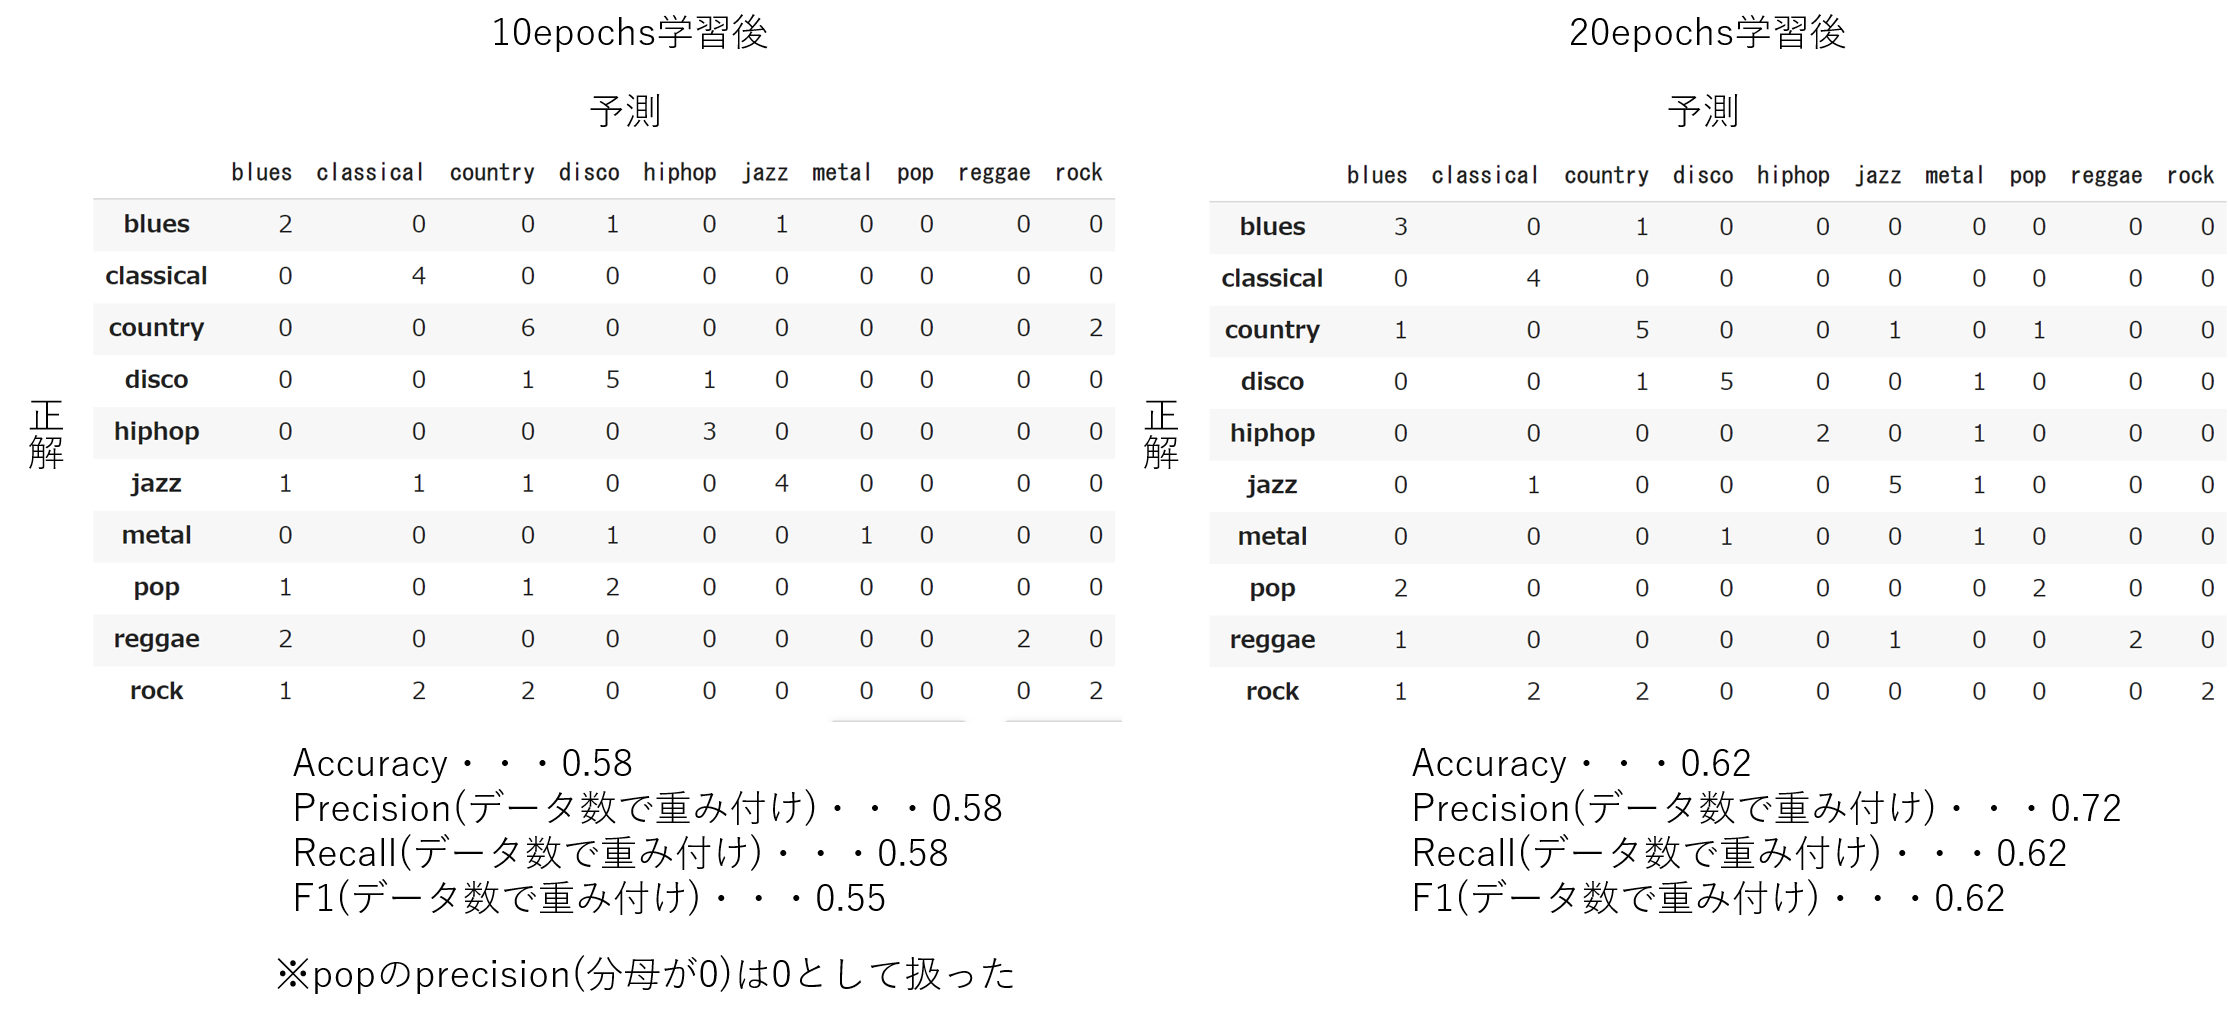

In [ ]:
Image.open("/content/music2vec/confusion_matrix.png")

## SoundNet出力を平坦化したものをPCA、t-SNEで可視化

### 学習前

In [ ]:
soundnet = build_model()

#### テストデータ

In [ ]:
output = soundnet.predict(test_inputs)

##### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(output.reshape(50,-1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
feature = pca.transform(output.reshape(50,-1))

In [ ]:
num_label = tf.math.argmax(test_labels,axis=1)

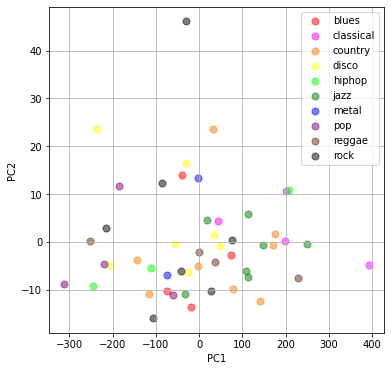

In [ ]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(50,-1))

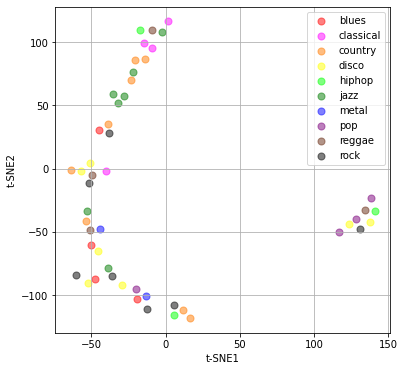

In [ ]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [ ]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(50,-1))

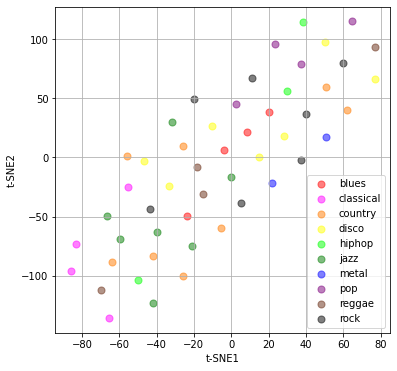

In [ ]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

#### 訓練データ

In [ ]:
output = soundnet.predict(x=pca_generator(train_filenames,train_labels,25),steps=38)

##### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(output.reshape(950,-1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
feature = pca.transform(output.reshape(950,-1))

In [ ]:
num_label = tf.math.argmax(train_labels,axis=1)

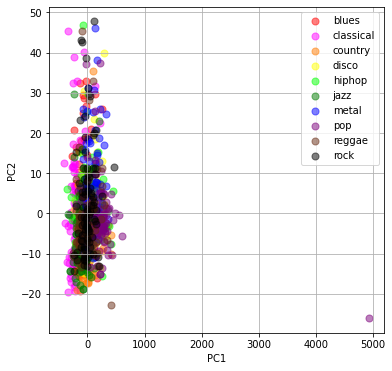

In [ ]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

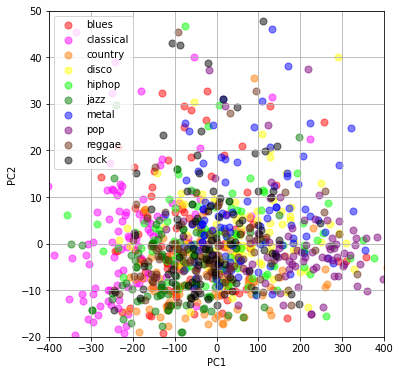

In [ ]:
# 拡大したPCA
plt.figure(figsize=(6, 6))

plt.xlim((-400,400))
plt.ylim((-20,50))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(950,-1))

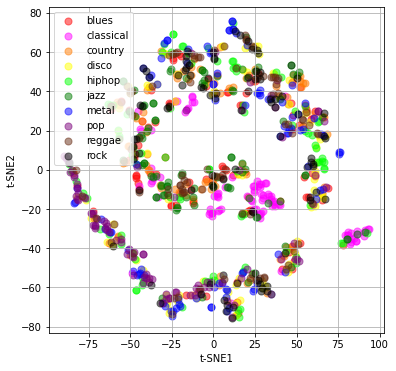

In [ ]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [ ]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(950,-1))

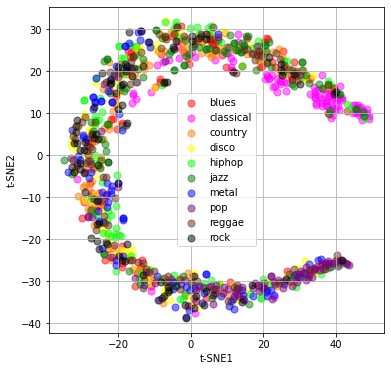

In [ ]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

### 10epochs学習後

In [ ]:
music2vec = tf.keras.models.load_model('/content/music2vec_10epochs.h5')

#### テストデータ

In [ ]:
soundnet = tf.keras.Model(inputs=music2vec.get_layer(index=1).input, outputs=music2vec.get_layer(index=1).output)

In [ ]:
output = soundnet.predict(test_inputs)

##### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(output.reshape(50,-1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
feature = pca.transform(output.reshape(50,-1))

In [ ]:
num_label = tf.math.argmax(test_labels,axis=1)

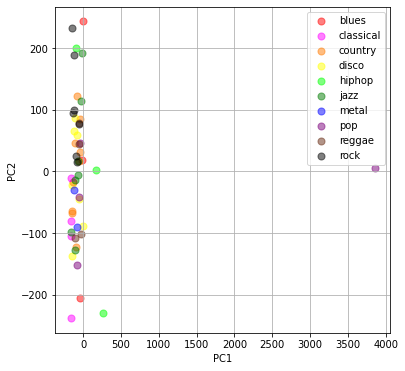

In [ ]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(50,-1))

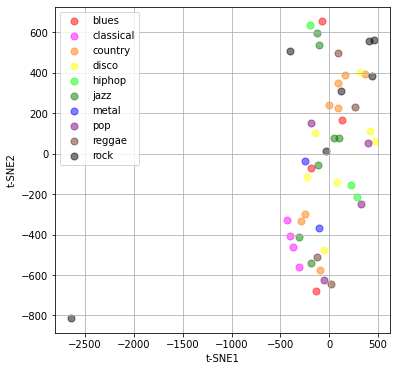

In [ ]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [ ]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(50,-1))

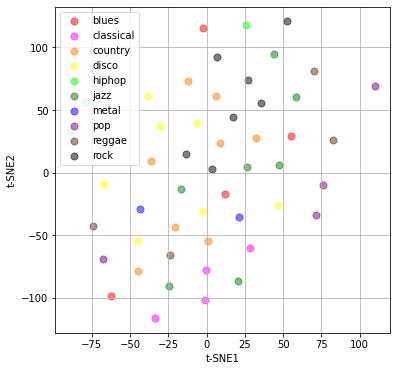

In [ ]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

#### 訓練データ

In [ ]:
output = soundnet.predict(x=pca_generator(train_filenames,train_labels,25),steps=38)

##### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(output.reshape(950,-1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
feature = pca.transform(output.reshape(950,-1))

In [ ]:
num_label = tf.math.argmax(train_labels,axis=1)

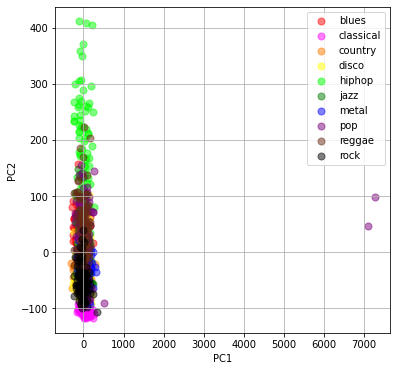

In [ ]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

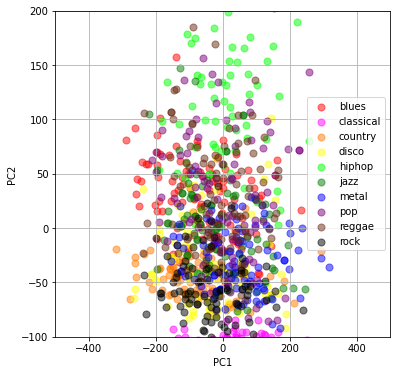

In [ ]:
# 拡大したPCA
plt.figure(figsize=(6, 6))

plt.xlim((-500,500))
plt.ylim((-100,200))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(950,-1))

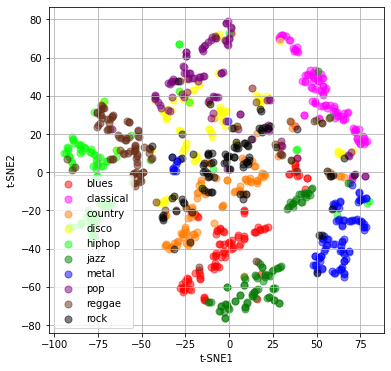

In [ ]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [ ]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(950,-1))

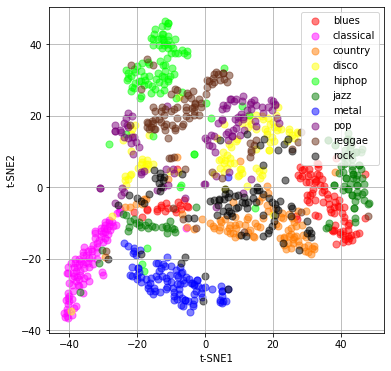

In [ ]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

### 20epochs学習後

In [ ]:
music2vec = tf.keras.models.load_model('/content/music2vec_20epochs.h5')

#### テストデータ

In [ ]:
soundnet = tf.keras.Model(inputs=music2vec.get_layer(index=1).input, outputs=music2vec.get_layer(index=1).output)

In [ ]:
output = soundnet.predict(test_inputs)

##### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(output.reshape(50,-1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
feature = pca.transform(output.reshape(50,-1))

In [ ]:
num_label = tf.math.argmax(test_labels,axis=1)

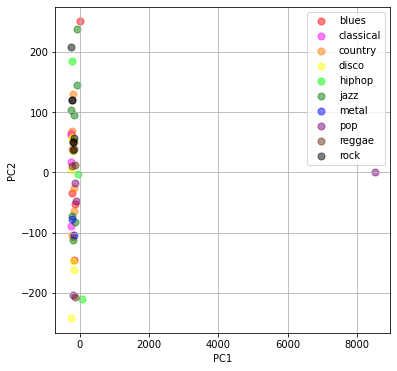

In [ ]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(50,-1))

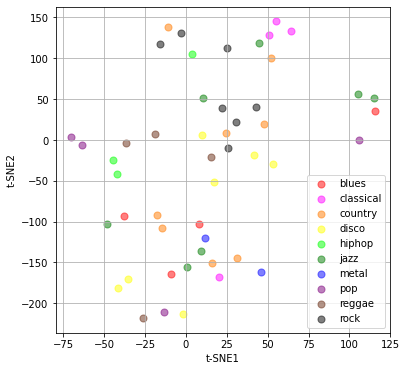

In [ ]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [ ]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(50,-1))

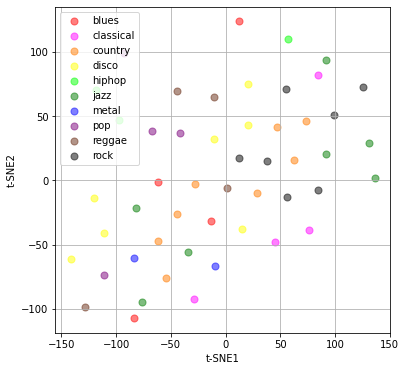

In [ ]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

#### 訓練データ

In [ ]:
output = soundnet.predict(x=pca_generator(train_filenames,train_labels,25),steps=38)

##### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(output.reshape(950,-1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
feature = pca.transform(output.reshape(950,-1))

In [ ]:
num_label = tf.math.argmax(train_labels,axis=1)

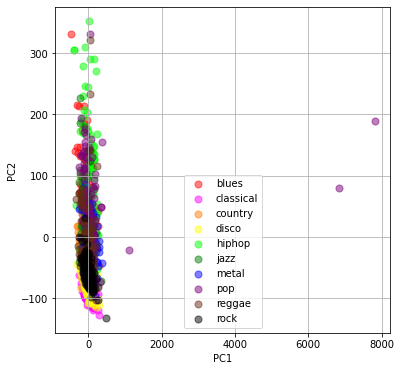

In [ ]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

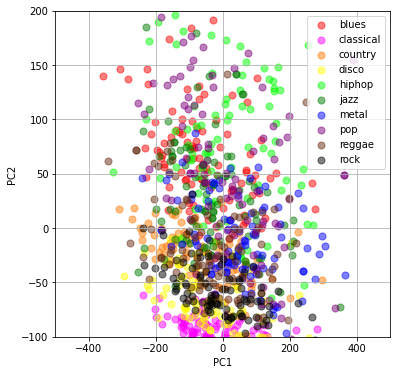

In [ ]:
# 拡大したPCA
plt.figure(figsize=(6, 6))

plt.xlim((-500,500))
plt.ylim((-100,200))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(950,-1))

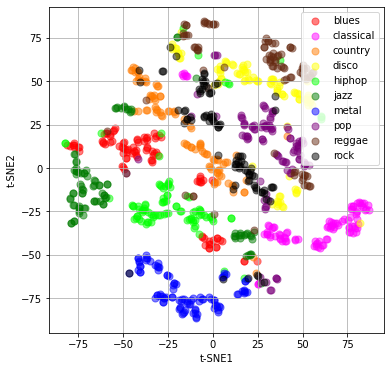

In [ ]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [ ]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(950,-1))

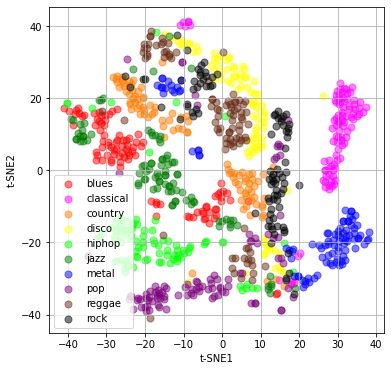

In [ ]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

### まとめ

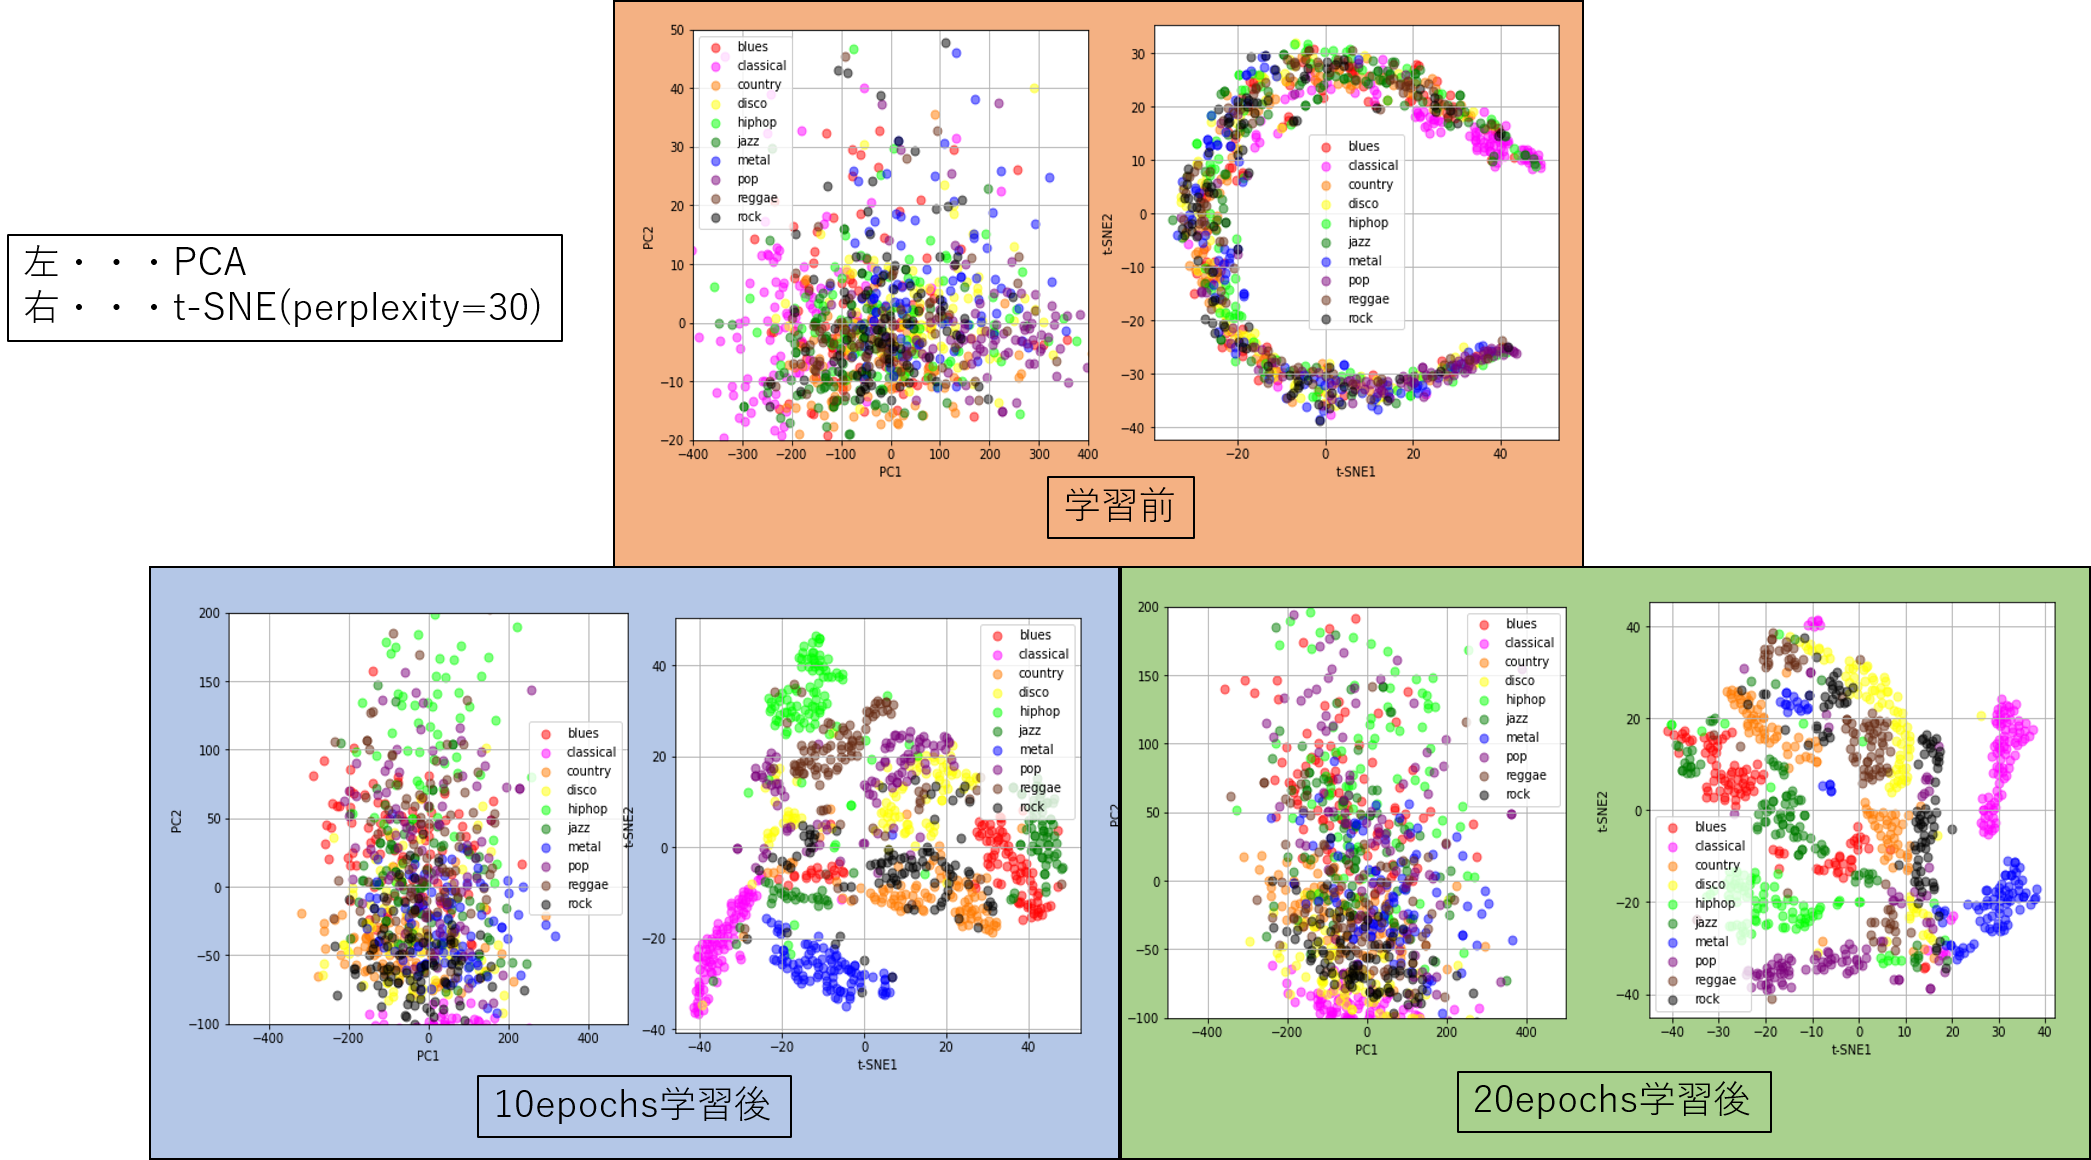

In [ ]:
Image.open("/content/music2vec/analysis.png")